In [1]:
import cv2
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from sklearn import model_selection
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [2]:
# global variables

INPUT_SHAPE_X = 256
INPUT_SHAPE_Y = 256
ITERATION = '1'
EPOCHS = 1000
BATCH_SIZE = 32

max_images = 600 # max images per class

In [3]:
# load labels
csv_path = 'data-labels/labels_preprocessed.csv'
labels = pd.read_csv(csv_path)
# replace NaN values with 0s
labels.fillna(0, inplace=True)

In [4]:
# load the images
head_path = 'data-pain'
head_dir = os.listdir(head_path)
x_head = []
y_head = []
i = 0
class_0 = 0
class_1 = 0
class_2 = 0

# iterate over images
for image in head_dir:
    # load the image
    image_path = os.path.join(head_path, image)
    try:
        img = tf.keras.preprocessing.image.load_img(image_path, target_size=(INPUT_SHAPE_X, INPUT_SHAPE_Y))
        img = tf.keras.preprocessing.image.img_to_array(img)
        
        # preprocess the image
        if (img is not None):
        
            # check image class
            image_class = labels.loc[labels['imageid'] == image, 'overall_impression']

            if not image_class.empty:
                image_class = image_class.iloc[0]    
                
                # append an equal number of images from each class
                if (image_class == 0.0 and class_0 < max_images):
                    x_head.append(img)
                    y_head.append(image_class)
                    class_0 += 1
                    if (i == max_images*3):
                        break
                    i+=1
                    
                    
                elif (image_class == 1.0 and class_1 < max_images):
                    x_head.append(img)
                    y_head.append(image_class)
                    class_1 += 1
                    if (i == max_images*3):
                        break
                    i+=1
                    
                    
                elif (image_class == 2.0 and class_2 < max_images):
                    x_head.append(img)
                    y_head.append(image_class)
                    class_2 += 1
                    if (i == max_images*3):
                        break
                    i+=1
    except:
        print("issue with", image_path)


issue with data-pain/8e8711a9-46da-4426-88cf-5e45195fa301.png
issue with data-pain/a70f45f6-cc25-47e4-a1f9-45b8ba808b0b.jpeg
issue with data-pain/df227fcd-408e-4b78-b04c-8301f4058ac5.jpeg
issue with data-pain/7f38ca2e-3fb1-4367-a9ae-b1fb6870ce49.jpeg
issue with data-pain/catpainface_labels.csv
issue with data-pain/95e03547-9050-4ec3-aadc-202f40ec9b02.jpeg
issue with data-pain/8f627658-98e9-49de-a6b9-ba68519c646c.jpeg
issue with data-pain/d9441afc-d81b-463e-9968-5ac51b81b244.jpg


In [5]:
# add flipped images from class 2
flipped_path = 'data/head-flipped'
for image in os.listdir(flipped_path):
    image_path = os.path.join(flipped_path, image)
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(INPUT_SHAPE_X, INPUT_SHAPE_Y))
    img = tf.keras.preprocessing.image.img_to_array(img)
    x_head.append(img)
    y_head.append(2)
    class_2 += 1

In [6]:
# add augmented images from class 2
aug_path = 'data/head-augmented'
for image in os.listdir(aug_path):
    image_path = os.path.join(aug_path, image)
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(INPUT_SHAPE_X, INPUT_SHAPE_Y))
    img = tf.keras.preprocessing.image.img_to_array(img)
    x_head.append(img)
    y_head.append(2)
    class_2 += 1

In [7]:
print(class_0, class_1, class_2)

600 600 1420


In [8]:
# preprocess
x_head = tf.keras.applications.vgg16.preprocess_input(np.array(x_head))

# split the dataset into train and test sets
x_train_val, x_test, y_train_val, y_test = model_selection.train_test_split(
    x_head, y_head, test_size=0.2, random_state=42)

# split the train and validation sets
x_train, x_val, y_train, y_val = model_selection.train_test_split(
    x_train_val, y_train_val, test_size=0.2, random_state=42)

# one-hot code labels
y_train = tf.cast(y_train,dtype=tf.int32)
y_val = tf.cast(y_val,dtype=tf.int32)
y_test = tf.cast(y_test,dtype=tf.int32)

y_train = tf.one_hot(y_train,3)
y_val = tf.one_hot(y_val,3)
y_test = tf.one_hot(y_test,3)

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-04-21 19:47:18.948452: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-21 19:47:18.948553: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
# create the model
model = tf.keras.models.Sequential()
model.add(tf.keras.applications.vgg16.VGG16(weights='weights/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                                            include_top=False,
                                            input_shape=(INPUT_SHAPE_X, INPUT_SHAPE_Y, 3)))
model.add(tf.keras.layers.Flatten(input_shape=model.output_shape[1:]))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(3, activation='softmax'))

In [10]:
# compile the model
earlystop = EarlyStopping(monitor='val_loss', patience=5)
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 256)               8388864   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               3

In [12]:
# train the model
hist = model.fit(x_train, y_train, 
              epochs=EPOCHS,
              batch_size=BATCH_SIZE, 
              validation_data=(x_val, y_val),
              callbacks=[earlystop])

Epoch 1/1000


2023-04-21 19:47:36.531237: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-21 19:47:36.875085: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


53/53 [==============================] - ETA: 0s - loss: 1.2853 - accuracy: 0.5113

2023-04-21 19:50:14.039291: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


53/53 [==============================] - 168s 3s/step - loss: 1.2853 - accuracy: 0.5113 - val_loss: 0.8463 - val_accuracy: 0.5405
Epoch 2/1000
53/53 [==============================] - 175s 3s/step - loss: 0.8582 - accuracy: 0.5489 - val_loss: 0.8291 - val_accuracy: 0.5643
Epoch 3/1000
53/53 [==============================] - 186s 4s/step - loss: 0.8277 - accuracy: 0.5680 - val_loss: 0.8218 - val_accuracy: 0.5690
Epoch 4/1000
53/53 [==============================] - 174s 3s/step - loss: 0.8069 - accuracy: 0.5805 - val_loss: 0.8136 - val_accuracy: 0.5905
Epoch 5/1000
53/53 [==============================] - 186s 4s/step - loss: 0.7780 - accuracy: 0.6217 - val_loss: 0.8549 - val_accuracy: 0.4857
Epoch 6/1000
53/53 [==============================] - 192s 4s/step - loss: 0.7373 - accuracy: 0.6432 - val_loss: 0.8350 - val_accuracy: 0.5548
Epoch 7/1000
53/53 [==============================] - 196s 4s/step - loss: 0.7008 - accuracy: 0.6748 - val_loss: 0.7717 - val_accuracy: 0.6190
Epoch 8/1000

In [55]:
# save the model and training history
path = 'model-eyes'
model.save(path)

history_df = pd.DataFrame(hist.history)
path = 'history-eyes.csv'
history_df.to_csv(path, index=False)

INFO:tensorflow:Assets written to: model-eyes/assets


INFO:tensorflow:Assets written to: model-eyes/assets


In [51]:
# evaluate the model
results = model.evaluate(x_test, y_test)
print(results)

29/29 [==============================] - 3s 98ms/step - loss: 1.3637 - accuracy: 0.6952
[1.3636865615844727, 0.6951754689216614]


In [13]:
# make predictions
prob_array = model.predict(x_test)
class_indices = np.argmax(prob_array, axis=1)

# convert the class indices to a one-hot encoded array
class_indices = np.argmax(prob_array, axis=1)
num_classes = 3
y_pred = np.zeros((prob_array.shape[0], num_classes))
y_pred[np.arange(prob_array.shape[0]), class_indices] = 1

 1/17 [>.............................] - ETA: 10s

2023-04-21 21:05:26.729837: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 13s 756ms/step


In [14]:
# make a classification report

print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))
print('\nClassification Report - eyes\n')
print(classification_report(y_test, y_pred, target_names=['Score 0', 'Score 1', 'Score 2']))


Accuracy: 0.56


Classification Report - eyes

              precision    recall  f1-score   support

     Score 0       0.50      0.19      0.27       117
     Score 1       0.38      0.15      0.21       128
     Score 2       0.59      0.91      0.72       279

   micro avg       0.56      0.56      0.56       524
   macro avg       0.49      0.42      0.40       524
weighted avg       0.52      0.56      0.49       524
 samples avg       0.56      0.56      0.56       524



Confusion Matrix

[[201 115  15]
 [ 80 198  39]
 [  1  28 235]]


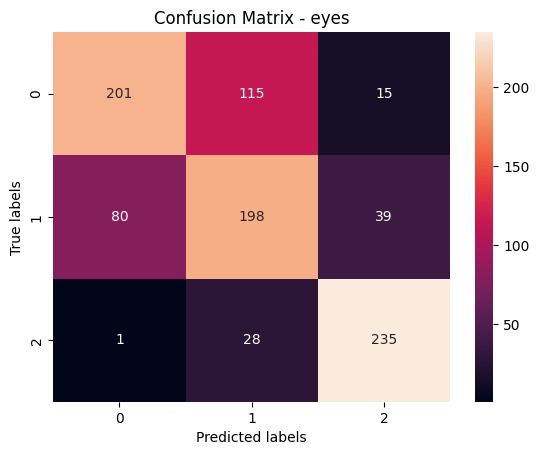

In [54]:
# make a confusion matrix
confusion = confusion_matrix(np.asarray(y_test).argmax(axis=1), np.asarray(y_pred).argmax(axis=1))
print('Confusion Matrix\n')
print(confusion)

lables = ['0','1','2']    
ax= plt.subplot()
sns.heatmap(confusion, annot=True, fmt='g', ax=ax);

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix - eyes'); 
ax.xaxis.set_ticklabels(lables); ax.yaxis.set_ticklabels(lables);
plt.show()